In [1]:
import os
import re
from statistics import mode

from PIL import Image
import numpy as np
import pandas
import torch
from torchvision import transforms

In [2]:
def process_text(text):
    # lowercase
    text = text.lower()

    # 数詞を数字に変換
    num_word_to_digit = {
        'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
        'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
        'ten': '10'
    }
    for word, digit in num_word_to_digit.items():
        text = text.replace(word, digit)

    # 小数点のピリオドを削除
    text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

    # 冠詞の削除
    text = re.sub(r'\b(a|an|the)\b', '', text)

    # 短縮形のカンマの追加
    contractions = {
        "dont": "don't", "isnt": "isn't", "arent": "aren't", "wont": "won't",
        "cant": "can't", "wouldnt": "wouldn't", "couldnt": "couldn't"
    }
    for contraction, correct in contractions.items():
        text = text.replace(contraction, correct)

    # 句読点をスペースに変換
    text = re.sub(r"[^\w\s':]", ' ', text)

    # 句読点をスペースに変換
    text = re.sub(r'\s+,', ',', text)

    # 連続するスペースを1つに変換
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [3]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, df_path, image_dir, transform=None, answer=True):
        self.transform = transform  # 画像の前処理
        self.image_dir = image_dir  # 画像ファイルのディレクトリ
        self.df = pandas.read_json(df_path)  # 画像ファイルのパス，question, answerを持つDataFrame
        self.answer = answer

        # question / answerの辞書を作成
        self.question2idx = {}
        self.answer2idx = {}
        self.idx2question = {}
        self.idx2answer = {}

        # 質問文に含まれる単語を辞書に追加
        for question in self.df["question"]:
            question = process_text(question)
            words = question.split(" ")
            for word in words:
                if word not in self.question2idx:
                    self.question2idx[word] = len(self.question2idx)
        self.idx2question = {v: k for k, v in self.question2idx.items()}  # 逆変換用の辞書(question)

        if self.answer:
            # 回答に含まれる単語を辞書に追加
            for answers in self.df["answers"]:
                for answer in answers:
                    word = answer["answer"]
                    word = process_text(word)
                    if word not in self.answer2idx:
                        self.answer2idx[word] = len(self.answer2idx)
            self.idx2answer = {v: k for k, v in self.answer2idx.items()}  # 逆変換用の辞書(answer)

    def update_dict(self, dataset):
        """
        検証用データ，テストデータの辞書を訓練データの辞書に更新する．

        Parameters
        ----------
        dataset : Dataset
            訓練データのDataset
        """
        self.question2idx = dataset.question2idx
        self.answer2idx = dataset.answer2idx
        self.idx2question = dataset.idx2question
        self.idx2answer = dataset.idx2answer

    def __getitem__(self, idx):
        """
        対応するidxのデータ（画像，質問，回答）を取得．

        Parameters
        ----------
        idx : int
            取得するデータのインデックス

        Returns
        -------
        image : torch.Tensor  (C, H, W)
            画像データ
        question : torch.Tensor  (vocab_size)
            質問文をone-hot表現に変換したもの
        answers : torch.Tensor  (n_answer)
            10人の回答者の回答のid
        mode_answer_idx : torch.Tensor  (1)
            10人の回答者の回答の中で最頻値の回答のid
        """
        image = Image.open(f"{self.image_dir}/{self.df['image'][idx]}")
        image = self.transform(image)
        question = np.zeros(len(self.idx2question) + 1)  # 未知語用の要素を追加
        # question_words = self.df["question"][idx].split(" ")
        question_words = process_text(self.df["question"][idx]).split(" ") # 質問文の前処理
        for word in question_words:
            try:
                question[self.question2idx[word]] = 1  # one-hot表現に変換
            except KeyError:
                question[-1] = 1  # 未知語

        if self.answer:
            answers = [self.answer2idx[process_text(answer["answer"])] for answer in self.df["answers"][idx]]
            mode_answer_idx = mode(answers)  # 最頻値を取得（正解ラベル）

            return image, torch.Tensor(question), torch.Tensor(answers), int(mode_answer_idx)

        else:
            return image, torch.Tensor(question)

    def __len__(self):
        return len(self.df)

In [4]:
# dataloader / model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# train_dataset = VQADataset(df_path="./data/train.json", image_dir="./data/train", transform=transform)
# test_dataset = VQADataset(df_path="./data/valid.json", image_dir="./data/valid", transform=transform, answer=False)
# test_dataset.update_dict(train_dataset)

In [5]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count(), persistent_workers=(os.name == 'nt'), pin_memory=True)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, persistent_workers=(os.name == 'nt'))
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, persistent_workers=(os.name == 'nt'))

In [6]:
# for image, question, answers, mode_answer in train_loader:
#     print(image.size(), question.size(), answers.size(), mode_answer.size())
#     break

In [7]:
# # dataの取り出し
# tmp = train_loader.__iter__()
# image, question, answers, mode_answer = tmp.next() 
# print(image.size(), question.size(), answers.size(), mode_answer.size())

In [8]:
df = pandas.read_json("./data/train.json")  # question, answerを持つDataFrame
df.head()

,image,question,answers
0,train_00000.jpg,What is this?,"[{'answer_confidence': 'yes', 'answer': 'beef ..."
1,train_00001.jpg,maybe it's because you're pushing it down instead,"[{'answer_confidence': 'yes', 'answer': 'unans..."
2,train_00002.jpg,What color is this item?,"[{'answer_confidence': 'yes', 'answer': 'grey'..."
3,train_00003.jpg,Can you tell me if this is like body wash or l...,"[{'answer_confidence': 'maybe', 'answer': 'lot..."
4,train_00004.jpg,Is it a paper?,"[{'answer_confidence': 'yes', 'answer': 'no'},..."


In [9]:
idx = 3

In [10]:
question = df['question'][idx]
print(question)

Can you tell me if this is like body wash or lotion or something like that?


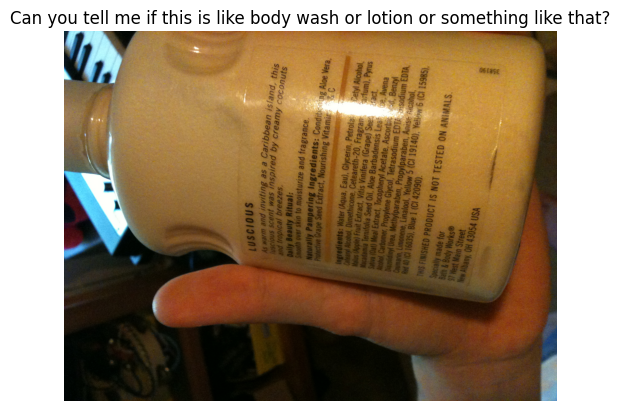

In [11]:
image_dir="./data/train"
image = Image.open(f"{image_dir}/{df['image'][idx]}")

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off')
ax.set_title(f'{question}')
plt.show()

In [12]:
from pprint import pprint

answers = df['answers'][idx]
pprint(answers)

[{'answer': 'lotion', 'answer_confidence': 'maybe'},
 {'answer': 'lotion', 'answer_confidence': 'maybe'},
 {'answer': 'unanswerable', 'answer_confidence': 'yes'},
 {'answer': 'yes', 'answer_confidence': 'yes'},
 {'answer': 'lotion', 'answer_confidence': 'yes'},
 {'answer': 'body wash', 'answer_confidence': 'yes'},
 {'answer': 'no', 'answer_confidence': 'yes'},
 {'answer': 'lotion', 'answer_confidence': 'maybe'},
 {'answer': 'lotion', 'answer_confidence': 'yes'},
 {'answer': 'lotion', 'answer_confidence': 'yes'}]


NVIDIA LAMB optimizerを使用する方法

- [NVIDIAでLAMBなどを使用する方法](https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587)
- [PythonのNVIDIA/apexがwindowsインストールできなかったのでメモ](https://note.com/kurogane_himaki/n/n5e8116954786)
- [【せっかち用】invalid command 'bdist_wheel' の対応方法](https://zenn.dev/ihcomirot/articles/2b054378779445)

In [13]:
from gensim.models import word2vec
# pip install gensim
# pip install scipy==1.12

In [14]:
class VQADatasetX(torch.utils.data.Dataset):
    def __init__(self, df_path, image_dir, transform=None, answer=True):
        self.transform = transform  # 画像の前処理
        self.image_dir = image_dir  # 画像ファイルのディレクトリ
        self.df = pandas.read_json(df_path)  # 画像ファイルのパス，question, answerを持つDataFrame
        self.answer = answer
        self.word2vec = None

        # question / answerの辞書を作成
        self.question2idx = {}
        self.answer2idx = {}
        self.idx2question = {}
        self.idx2answer = {}
        self.sample_sentence = []

        # 質問文に含まれる単語を辞書に追加
        for question in self.df["question"]:
            question = process_text(question)
            words = question.split(" ")
            self.sample_sentence.append(words)
            print(words)
            for word in words:
                if word not in self.question2idx:
                    self.question2idx[word] = len(self.question2idx)
        self.idx2question = {v: k for k, v in self.question2idx.items()}  # 逆変換用の辞書(question)
        print(self.sample_sentence)
        self.word2vec = word2vec.Word2Vec(sentences=self.sample_sentence, vector_size=100, min_count=1, window=5)

        if self.answer:
            # 回答に含まれる単語を辞書に追加
            for answers in self.df["answers"]:
                for answer in answers:
                    word = answer["answer"]
                    word = process_text(word)
                    if word not in self.answer2idx:
                        self.answer2idx[word] = len(self.answer2idx)
            self.idx2answer = {v: k for k, v in self.answer2idx.items()}  # 逆変換用の辞書(answer)

    def update_dict(self, dataset):
        """
        検証用データ，テストデータの辞書を訓練データの辞書に更新する．

        Parameters
        ----------
        dataset : Dataset
            訓練データのDataset
        """
        self.question2idx = dataset.question2idx
        self.answer2idx = dataset.answer2idx
        self.idx2question = dataset.idx2question
        self.idx2answer = dataset.idx2answer

    def __getitem__(self, idx):
        """
        対応するidxのデータ（画像，質問，回答）を取得．

        Parameters
        ----------
        idx : int
            取得するデータのインデックス

        Returns
        -------
        image : torch.Tensor  (C, H, W)
            画像データ
        question : torch.Tensor  (vocab_size)
            質問文をone-hot表現に変換したもの
        answers : torch.Tensor  (n_answer)
            10人の回答者の回答のid
        mode_answer_idx : torch.Tensor  (1)
            10人の回答者の回答の中で最頻値の回答のid
        """
        image = Image.open(f"{self.image_dir}/{self.df['image'][idx]}")
        image = self.transform(image)
        # question = np.zeros(len(self.idx2question) + 1)  # 未知語用の要素を追加
        # # question_words = self.df["question"][idx].split(" ")
        question_words = process_text(self.df["question"][idx]).split(" ") # 質問文の前処理
        # for word in question_words:
        #     try:
        #         question[self.question2idx[word]] = 1  # one-hot表現に変換
        #     except KeyError:
        #         question[-1] = 1  # 未知語
        question = self.word2vec.wv[question_words]
        print(question)

        if self.answer:
            answers = [self.answer2idx[process_text(answer["answer"])] for answer in self.df["answers"][idx]]
            mode_answer_idx = mode(answers)  # 最頻値を取得（正解ラベル）

            return image, torch.Tensor(question), torch.Tensor(answers), int(mode_answer_idx)

        else:
            return image, torch.Tensor(question)

    def __len__(self):
        return len(self.df)

In [15]:
# dataloader / model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_datasetX = VQADatasetX(df_path="./data/train.json", image_dir="./data/train", transform=transform)

['what', 'is', 'this']
['maybe', "it's", 'because', "you're", 'pushing', 'it', 'down', 'instead']
['what', 'color', 'is', 'this', 'item']
['can', 'you', 'tell', 'me', 'if', 'this', 'is', 'like', 'body', 'wash', 'or', 'lotion', 'or', 'something', 'like', 'that']
['is', 'it', 'paper']
['what', 'is', 'this']
['what', 'is', 'this']
['what', 'device', 'is', 'this']
['please', 'tell', 'me', 'what', 'this', 'is']
['is', 'this', 'brown', 'rice', 'or', 'white', 'rice']
['can', 'you', 'tell', 'me', 'if', 'this', 'is', 'mild', 'or', 'hot', 'please', 'thank', 'you']
['what', 'is', 'this']
['what', 'color', 'is', 'this', 't', 'shirt']
['what', 'kind', 'of', 'note', 'is', 'that']
["what's", 'in', 'this', 'package']
['what', 'color', 'is', 'this']
["what's", 'in', 'this', 'can']
['what', 'is', 'this']
['what', 'color', 'is', 'this']
['what', 'is', 'this']
['when', 'does', 'this', 'expire']
['what', 'color', 'is', 'this', 'shirt', 'thank', 'you']
['what', 'is', 'in', 'this', 'container']
['what', 'is'

In [16]:
train_loaderX = torch.utils.data.DataLoader(train_datasetX, batch_size=128, shuffle=False, num_workers=os.cpu_count(), persistent_workers=(os.name == 'nt'), pin_memory=True)

In [17]:
# for image, question, answers, mode_answer in train_loaderX:
#     print(image.size(), question.size(), answers.size(), mode_answer.size())
#     break

In [1]:
from transformers import BertTokenizer, BertModel

d:\Documents\Works\PythonWorks\dl_lecture_competition_pub\.venv_VQA-competition\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# BERTの日本語モデル
# MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# BERTの英語モデル
MODEL_NAME = 'bert-base-uncased'

#トークナイザとモデルのロード
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

text = 'what is this'
tokenized_text = tokenizer.tokenize(text)
tokenized_text.insert(0, "[CLS]")
tokenized_text.append("[SEP]")
print(tokenized_text)

d:\Documents\Works\PythonWorks\dl_lecture_competition_pub\.venv_VQA-competition\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nopeet\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


['[CLS]', 'what', 'is', 'this', '[SEP]']


In [6]:
import torch

model = BertModel.from_pretrained(MODEL_NAME)
# model = model.cuda()

def get_embedding(text):
    tokens = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

embedding = get_embedding(text)
print(embedding)

[ 3.48340496e-02 -7.69418254e-02 -2.96215471e-02 -2.53321469e-01
  3.23072188e-02 -1.92334816e-01 -3.05886026e-02  3.81107986e-01
 -2.53836811e-01 -3.42316717e-01  1.78451482e-02 -4.68976498e-01
 -3.72093081e-01  6.28604293e-01 -3.14186662e-01  1.04628846e-01
  2.27756709e-01 -5.11579998e-02  5.63182542e-03  4.25803900e-01
 -1.07455015e-01  3.39351952e-01 -4.44540650e-01  1.23872899e-01
  3.14482212e-01  3.56344998e-01 -3.63940209e-01 -7.71258473e-02
  1.60198566e-02 -2.27971077e-01  3.99843037e-01  8.78291801e-02
 -3.94535542e-01 -3.24566811e-01 -2.06307977e-01  4.66284305e-02
 -1.36060148e-01 -2.25882366e-01 -3.94315124e-01  2.01453894e-01
 -7.96079516e-01 -1.02977015e-01 -4.98367921e-02  1.07958578e-01
 -2.42428944e-01 -5.10461390e-01  1.47225887e-01 -2.23988146e-01
 -7.30170131e-01  2.15507179e-01 -2.81222612e-01  2.84965098e-01
  4.76966836e-02  1.36296511e-01 -2.31230780e-01  2.65681833e-01
  3.00861411e-02 -4.99635696e-01  9.32442304e-03  2.82781683e-02
  3.79157454e-01  4.38314